# **AI-Powered Receipt Analyzer:**

# **Install Libraries:**

In [17]:
!pip install easyocr
!pip install transformers
!pip install pillow
!pip install opencv-python
!pip install pandas matplotlib

# **Import Libraries:**

In [18]:
import easyocr
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import re

# **Upload Receipt Image:**

In [19]:
from google.colab import files
uploaded = files.upload()

Saving Food-Delivery-Receipt-Template-edit-online.png to Food-Delivery-Receipt-Template-edit-online (1).png


### **After upload:**

(np.float64(-0.5), np.float64(1199.5), np.float64(1695.5), np.float64(-0.5))

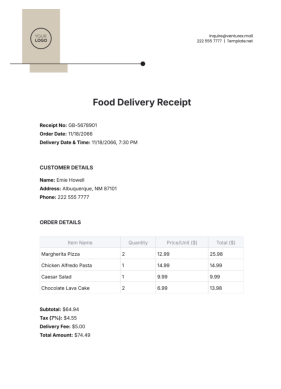

In [20]:
image_path = list(uploaded.keys())[0]
image = cv2.imread(image_path)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis("off")

# **Image Preprocessing:**

Why? OCR works better on clean images.

(np.float64(-0.5), np.float64(1199.5), np.float64(1695.5), np.float64(-0.5))

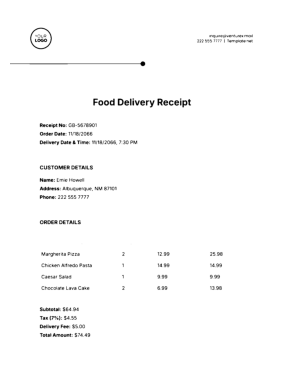

In [21]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5), 0)
thresh = cv2.threshold(blur, 150, 255, cv2.THRESH_BINARY)[1]

plt.imshow(thresh, cmap="gray")
plt.axis("off")

# **OCR using EasyOCR:**

In [22]:
reader = easyocr.Reader(['en'])
results = reader.readtext(image) # Changed to use the original 'image'

texts = [text[1] for text in results]
print("Extracted Texts:", texts) # Added print statement for debugging
for t in texts:
    print(t)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Extracted Texts: ['YOUR', 'inquire@venturexmail', 'LOGO', '222 555 7777', 'Template net', 'Food Delivery Receipt', 'Receipt No: GB-5678901', 'Order Date: 11/18/2066', 'Delivery Date & Time: 11/18/2066,7.30 PM', 'CUSTOMER DETAILS', 'Name: Emie Howell', 'Address: Albuquerque', 'NM 87101', 'Phone: 222 555 7777', 'ORDER DETAILS', 'Item Name', 'Quantity', 'Price/Unit', 'Total', 'S)', 'Margherita Pizza', '12.99', '25.98', 'Chicken Alfredo Pasta', '14.99', '14.99', 'Caesar Salad', '9.99', '9.99', 'Chocolate Lava Cake', '2', '6.99', '13.98', 'Subtotal: $64.94', 'Tax (7%): S4.55', 'Delivery Fee: $5.00', 'Total Amount: $74.49']
YOUR
inquire@venturexmail
LOGO
222 555 7777
Template net
Food Delivery Receipt
Receipt No: GB-5678901
Order Date: 11/18/2066
Delivery Date & Time: 11/18/2066,7.30 PM
CUSTOMER DETAILS
Name: Emie Howell
Address: Albuquerque
NM 87101
Phone: 222 555 7777
ORDER DETAILS
Item Name
Quantity
Price/Unit
Total
S)
Margherita Pizza
12.99
25.98
Chicken Alfredo Pasta
14.99
14.99
Caesar 

# **Parse Items and Prices:**

In [33]:
import re
import pandas as pd

items = []
prices = []

# Keywords/patterns to ignore or identify as non-item lines
ignore_patterns = [
    r'your', r'inquire@venturexmail', r'logo', r'template net', r'food delivery receipt',
    r'receipt no:', r'order date:', r'delivery date & time:', r'customer details',
    r'name:', r'address:', r'nm \d{5}', r'phone:', r'order details', r'item name',
    r'quantity', r'price/unit', r'total', r's\)', # 'S)' for currency symbol detected
    r'amt', r'gubtotil', r'blce', # Common OCR errors or irrelevant text
    r'\d{3}\s*\d{3}\s*\d{4}' # General phone number pattern
]

# Summary line patterns
summary_patterns = {
    'subtotal': r'(subtotal)[:\s]*\$?(\d+[.,]\d{2})',
    'tax': r'(tax)\s*\(?(?:\d+%)?[:]?[\s]*\$?(\d+[.,]\d{2})',
    'delivery fee': r'(delivery fee)[:\s]*\$?(\d+[.,]\d{2})',
    'total amount': r'(total amount)[:\s]*\$?(\d+[.,]\d{2})'
}

# Regex for a price value (e.g., '12.99' or '$12,99')
price_value_pattern = r'\$?(\d+[.,]\d{2})'

i = 0
while i < len(texts):
    current_text = texts[i].strip()
    current_text_lower = current_text.lower()

    # --- Check for Ignore Patterns ---
    if any(re.search(pattern, current_text_lower) for pattern in ignore_patterns):
        i += 1
        continue

    # --- Check for Summary Lines (e.g., Subtotal, Tax, Delivery Fee, Total Amount) ---
    summary_found = False
    for summary_key, pattern_str in summary_patterns.items():
        match = re.search(pattern_str, current_text_lower, re.IGNORECASE)
        if match:
            item_name = match.group(1).replace('$', '').strip() # Get the summary label (e.g., 'subtotal')
            price_str = match.group(2).replace(',', '.') # Get the price value
            items.append(item_name)
            prices.append(float(price_str))
            summary_found = True
            break
    if summary_found:
        i += 1
        continue

    # --- Handle Individual Items ---
    # If not an ignore pattern and not a summary line, treat as potential item name
    # Also, ensure it's not just a pure number (like a quantity) or a price by itself.
    if not re.fullmatch(r'\d+', current_text) and not re.fullmatch(price_value_pattern, current_text):
        item_name_candidate = current_text
        found_prices_for_this_item = []

        j = i + 1
        while j < len(texts):
            next_text = texts[j].strip()
            next_text_lower = next_text.lower()

            # If we hit an ignore pattern, a summary line, or another obvious item name,
            # stop looking for prices for the current item.
            if any(re.search(s_pattern, next_text_lower) for s_pattern in summary_patterns.values()) or \
               any(re.search(i_pattern, next_text_lower) for i_pattern in ignore_patterns) or \
               (not re.fullmatch(r'\d+', next_text) and not re.fullmatch(price_value_pattern, next_text) and \
                not next_text_lower in ['quantity', 'price/unit', 'total']): # 'total' is a header, not a price for preceding item
                break

            # If it's a price, add it to potential prices for this item
            price_match = re.search(price_value_pattern, next_text)
            if price_match:
                found_prices_for_this_item.append(float(price_match.group(1).replace(',', '.')))

            j += 1

        # After looking ahead, if prices were found, take the *last* one as the item's total.
        # This assumes the receipt lists quantity, unit price, then total price for an item.
        if found_prices_for_this_item:
            items.append(item_name_candidate)
            prices.append(found_prices_for_this_item[-1]) # Take the last found price as the total
            i = j # Move main iterator past the prices associated with this item
            continue

    i += 1 # Move to the next line if no specific rule applied

df = pd.DataFrame({
    "Item": items,
    "Price": prices
})

# Filter out rows where Price is 0 or Item is very short (potential parsing errors)
df = df[df['Price'] > 0]
df = df[df['Item'].str.len() > 1] # Filter out single characters or empty strings

df

,Item,Price
0,Margherita Pizza,25.98
1,Chicken Alfredo Pasta,14.99
2,Caesar Salad,9.99
3,Chocolate Lava Cake,13.98
4,delivery fee,5.00


# **Categorize Expenses:**

In [34]:
def categorize(item):
    item = item.lower()
    if any(x in item for x in ['milk','cheese','yogurt']):
        return "Dairy"
    elif any(x in item for x in ['bread','cake','bun']):
        return "Bakery"
    elif any(x in item for x in ['chicken','beef','meat']):
        return "Meat"
    elif any(x in item for x in ['chips','snack','cola']):
        return "Snacks"
    else:
        return "Other"

df["Category"] = df["Item"].apply(categorize)
df

,Item,Price,Category
0,Margherita Pizza,25.98,Other
1,Chicken Alfredo Pasta,14.99,Meat
2,Caesar Salad,9.99,Other
3,Chocolate Lava Cake,13.98,Bakery
4,delivery fee,5.00,Other


# **Spending Analysis:**
Total per category

In [35]:
category_summary = df.groupby("Category")["Price"].sum().reset_index()
category_summary

,Category,Price
0,Bakery,13.98
1,Meat,14.99
2,Other,40.97


### **Total spending:**

In [36]:
total_spent = df["Price"].sum()
print("Total Spending:", total_spent)

Total Spending: 69.94


### **Percentage:**

In [37]:
category_summary["Percentage"] = (category_summary["Price"] / total_spent) * 100
category_summary

,Category,Price,Percentage
0,Bakery,13.98,19.988562
1,Meat,14.99,21.432657
2,Other,40.97,58.578782


# **Visualization:**

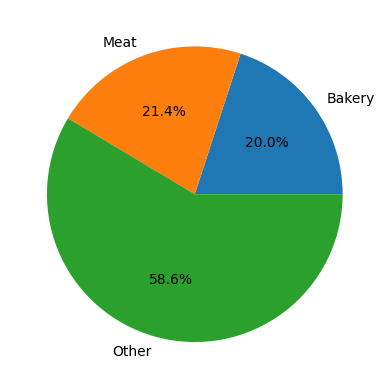

In [38]:
plt.figure()
plt.pie(category_summary["Price"], labels=category_summary["Category"], autopct="%1.1f%%")
plt.show()

# **LLM Financial Advice:**
### Install model:

In [39]:
from transformers import pipeline

generator = pipeline("text-generation", model="distilgpt2")

Loading weights:   0%|          | 0/76 [00:00<?, ?it/s]

GPT2LMHeadModel LOAD REPORT from: distilgpt2
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
transformer.h.{0, 1, 2, 3, 4, 5}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


### Prepare prompt:

In [40]:
summary_text = category_summary.to_string()

prompt = f"""
This is a person's spending summary:
{summary_text}

Give budgeting advice and highlight overspending areas.
"""

### Generate advice:

In [41]:
advice = generator(prompt, max_length=200, num_return_sequences=1)
print(advice[0]['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



This is a person's spending summary:
  Category  Price  Percentage
0   Bakery  13.98   19.988562
1     Meat  14.99   21.432657
2    Other  40.97   58.578782

Give budgeting advice and highlight overspending areas.
You can make more money on the food supply. You can change the way you consume your food because you can.
But if you want to make money on the food supply, you should consider making your own.
You should consider making your own. If you want to make money on the food supply, you should consider making your own. If you want to make money on the food supply, you should consider making your own.
If you want to make money on the food supply, you should consider making your own. If you want to make money on the food supply, you should consider making your own. If you want to make money on the food supply, you should consider making your own. If you want to make money on the food supply, you should consider making your own.
If you want to make money on the food supply, you should 

Conclusion:

This AI-Powered Receipt Analyzer automates manual expense tracking by converting receipt images into structured financial insights. The system uses image preprocessing and OCR to extract text, applies pattern recognition to detect monetary values, and generates analytical summaries with visualizations. This solution reduces manual effort, improves financial transparency, and can be integrated into personal finance or business expense management systems. The project demonstrates the practical use of Computer Vision, NLP, and Data Analytics in a real-world automation scenario.
### Workflow:
✔ OCR extraction

✔ Structured DataFrame

✔ Category analysis

✔ Spending percentages

✔ Chart

✔ AI advice